In [ ]:
saved01={'eta': 0.04977302771468815,
 'gamma': 3.436978974314692,
 'max_depth': 14,
 'reg_alpha': 0.560951516554309,
 'reg_lambda': 0.7721206743031015,
 'subsample': 0.6367637302171308,
 'objective': 'binary:hinge',
 'importance_type': 'gain',
 'tree_method': 'exact',
 'seed': 955,
 'booster': 'dart'}

saved001={'eta': 0.07436594021379316,
 'gamma': 3.258529695070266,
 'max_depth': 12,
 'reg_alpha': 1.3949887265827887,
 'reg_lambda': 0.12000652906703557,
 'subsample': 0.6401068782294695,
 'objective': 'binary:hinge',
 'importance_type': 'total_gain',
 'seed': 584,
 'booster': 'gbtree'}

saved002={'eta': 0.07308159533285616,
 'gamma': 3.8021276063464664,
 'reg_alpha': 1.0602091393972672,
 'reg_lambda': 1.1830168959249403,
 'subsample': 0.7414806445712182,
 'importance_type': 'gain',
 'seed': 857,
 'booster': 'dart',
 'objective': 'binary:hinge',
 'max_depth': 27}

# **Bank Term Deposition Marketing Campaigns Outcome Classification Prediction Model**
## **Introduction**
### Dataset Overview
The data model study below is based on Kaggle open dataset: https://www.kaggle.com/datasets/thedevastator/bank-term-deposit-predictions

This dataset, titled Direct Marketing Campaigns for Bank Term Deposits, is a collection of data related to the direct marketing campaigns conducted by a Portuguese banking institution. These campaigns primarily involved phone calls with customers, and the objective was to determine whether or not a customer would subscribe to a term deposit offered by the bank. Most of the outcomes of the dataset is 'unsuccessful' (i.e. **unbalanced data**), therefore the study will prioritize on balanced accuracy (i.e. simple average accuracy of successful and unsuccessful outcome, instead of weight average accuracy of the two outcomes) and recall.

### Objective
The goal is to predict the outcome of the marketing campaign by training model with provided data, and study what are the key factors affecting the result.

### Model Training Flow
1. Data Cleaning & Exploration
2. Data Transformation
3. Model Selection
4. Base Model Training
5. Feature Engineering and Model Finetune
6. Conclusion

## **Import Libaries**
Common libraries for data plotting and model training.
Optuna library is used for model hyperparameter optimization.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
rs= RobustScaler()
from sklearn.preprocessing import OrdinalEncoder
oe=OrdinalEncoder()
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
from sklearn.preprocessing import OneHotEncoder
ohe=OneHotEncoder()

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression

import optuna

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import recall_score
from sklearn.metrics import balanced_accuracy_score

import shap

import warnings
warnings.filterwarnings('ignore')

## **1. Data Cleaning & Exploration**
### **Section Summary:**
Train and test data sets with 10:1 ratio are given, with no observable data integrity issues. The target response (successful subsription) is binary value (colum 'y'= 'yes' or 'no'), with ~11% are successful subsribption, hence it is an imbalanced data set.
![alt text](imbalanced.jpg)

The data sets contain informations of customer and marketing campaign, there are approximately 45k entries in train data set. It consist of categorical and numberical values. Although most data are distributed evenly, few factor such as balance, pday etc have high outliers and require standardizaion transformation.

### **Section Highlights:**
1. The data set contains train.csv and test.csv. We will split the train.csv into train and validation data sets and perform cross validation training; the test.csv will be used as out-of-sample test data.
    1. train.csv 45,211 cols x 17 rows.
    2. test.csv 4,521 cols x 17 rows.
2. The outcome (i.e. target response) is 'y' column, with values either 'yes' or 'no'.
3. Data columns (i.e. features) contain:
    1. Customer information. eg: age, job, marital, education, balance, housing, loan.
    2. Marketing information. eg: contact (method), (contact) day and monnth, duration (since last marketing campaign, in second), pdays (duration since last marketing campaign, in day), poutcome(marketing campaign outcome).
4. There is no clear date time information when the marketing campaign was conducted (only day and month).
5. Basic data validation is done, no significant data integrity issue is found.
6. No strong distinctions are found. Few factors have high outliers

In [2]:
df_tr=pd.read_csv("train.csv")
df_tst=pd.read_csv("test.csv")

Overview of train and test sets: No abnormality

In [ ]:
df_tr

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,yes
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,yes
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,no


In [ ]:
df_tst

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4516,33,services,married,secondary,no,-333,yes,no,cellular,30,jul,329,5,-1,0,unknown,no
4517,57,self-employed,married,tertiary,yes,-3313,yes,yes,unknown,9,may,153,1,-1,0,unknown,no
4518,57,technician,married,secondary,no,295,no,no,cellular,19,aug,151,11,-1,0,unknown,no
4519,28,blue-collar,married,secondary,no,1137,no,no,cellular,6,feb,129,4,211,3,other,no


Imbalanced data is found in both train and test data.

In [ ]:
fig = go.Figure()
fig.add_trace(
    go.Histogram(
        x=df_tr['y'],
        name='Train',
        #text_auto=True,
        )
        )

fig.add_trace(
    go.Histogram(
        x=df_tst['y'],
        name='Test',
        #text_auto=True,
        )
        )

fig.update_layout(
    title_text='Imbalanced Data: Successful outcomes are only accounted for ~11 percentage of total sample',
    xaxis_title_text='y',
    yaxis_title_text='Count',
    barmode='stack',
)

Unique value, duplication and null checks for train and test data sets: No abnormality

In [ ]:
df_tr.nunique()

age            77
job            12
marital         3
education       4
default         2
balance      7168
housing         2
loan            2
contact         3
day            31
month          12
duration     1573
campaign       48
pdays         559
previous       41
poutcome        4
y               2
dtype: int64

In [ ]:
df_tst.nunique()

age            67
job            12
marital         3
education       4
default         2
balance      2353
housing         2
loan            2
contact         3
day            31
month          12
duration      875
campaign       32
pdays         292
previous       24
poutcome        4
y               2
dtype: int64

In [ ]:
df_tr.duplicated().sum()

0

In [ ]:
df_tst.duplicated().sum()

0

In [ ]:
df_tr.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

In [ ]:
df_tst.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

### Data visualization
The key takeaways are:
1. Most data are evenly distributed.
2. There are extreme points and suggest to use data standardization transformation.
3. Few minor distinction are found but not conclusive.

For numberic feature vs catagorical feature, violin plot is used to compare the distribution of target response with 'yes' and 'no'
![alt text](EDA_viz1.jpg)

If both features are numeric, scatter plot is used to cheack overall distribution with color label of 'yes' and 'no'
![alt text](EDA_viz2.jpg)

If both features are categorical, histrogram subplot is used to compare the distribution of 'yes' and 'no'. The y-axis is normalized into count density (percentage) of each outcome to have better contrast in visualization since this is imbalanced data
![alt text](EDA_viz3.jpg)

The function viz_all will generate plots for all features combination (total 135 plots).

In [4]:
#To run viz for all columns vs response
def viz_all(df,target_response):
    df_tr=df.drop(target_response,axis=1)
    numerical_ix = df_tr.select_dtypes(include=['int64', 'float64']).columns
    categorical_ix = df_tr.select_dtypes(include=['object', 'bool']).columns
    count=0

    for i in numerical_ix:
        for j in categorical_ix:
            count=count+1
            plt.figure(figsize=(20,10))
            sns.violinplot(df,x=j, y=i,split=True,hue=target_response,gap=.1, inner="quart")
            plt.xticks(rotation=60,fontsize=8)
            plt.title(f"Plot {count}: Violin plot using numberic variable vs categorical variable with target response as legend:\n {i} vs {j} with {target_response} as legend")

        for j in numerical_ix:
            if j!=i:
                count=count+1
                plt.figure(figsize=(20,10))
                sns.scatterplot(df,x=j, y=i,hue=target_response,style=target_response)
                plt.title(f"Plot {count}: Scatter plot using numberic variable vs numberic variable with target response as legend:\n {i} vs {j} with {target_response} as legend")

    for i in categorical_ix:
        for j in categorical_ix:
            if j!=i:
                if len(pd.unique(df[i]))>len(pd.unique(df[j])):
                    count=count+1
                    fig, axes= plt.subplots(1,2,figsize=(15, 5),sharey=True,tight_layout=True)
                    fig.suptitle(f'Plot {count}: {i} vs {j}')
                    sns.histplot(ax=axes[0],data=df.loc[df['y']=='yes'].sort_values(by=i), x=i,hue=j,stat='percent', multiple='stack').tick_params(labelrotation=60)
                    axes[0].set_title('y=yes')
                    sns.histplot(ax=axes[1],data=df.loc[df['y']=='no'].sort_values(by=i), x=i,hue=j,stat='percent', multiple='stack').tick_params(labelrotation=60)
                    axes[1].set_title('y=no')

In [ ]:
viz_all(df_tr,'y')

## **2. Data Transformation & Spliting**
### **Summary:**
Transform month from text into number, and apply transformation for categorical data, and standardized numberical data to reduce impact from outliers.
Data spliting is following train-validation-test split.

### **Section Highlights:**
Data transformations logic:
1. Hardcode to Convert 'month' into numeric number of month.
2. 'y' column (target response) -> label encoder.
3. Categorical featre with bindary value -> label encoder.
4. Categorical feature with multiple values -> one-hot enccoder instead of label encoder, to avoid ranking effect.
5. Numberical feature -> robus-scaler encoder, to reduced outlier impact.

Test dataset is restricted for final model result testing and is not used for model tuning; Train data is split into train and validation dataset with 80:20 ratio. Train data is used for model train while validation data is used to validate tuning result. 

Cross validation is used and will be elaborated more in next section.

In [ ]:
#Apply Ordinary Encoder to (binary) response, One Hot Encoder to categorical col, and Robust Scaler to numberical col
def pro_df(tr,response):
    #convert month into number
    df_tr=tr.replace({'may':5, 'jun':6, 'jul':7, 'aug':8, 'oct':10, 'nov':11, 'dec':12, 'jan':1, 'feb':2,'mar':3, 'apr':4, 'sep':9})

    #convert cat response into ordinal
    resp_df=pd.DataFrame(df_tr[response])
    pro_resp=df_tr[[response]].apply(le.fit_transform)
    df_tr=df_tr.drop(response,axis=1)
    
    binary_cat_col=[]
    for i in df_tr.nunique().keys():
        if df_tr.nunique()[i]<=2:
            binary_cat_col.append(i)

    num_col=df_tr.select_dtypes(include=['int64', 'float64']).columns
    num_col=num_col.drop(['month','day'])
    cat_col= df_tr.select_dtypes(include=['object', 'bool']).columns
    cat_col=cat_col.drop(binary_cat_col)

    pro_num=pd.DataFrame(rs.fit_transform(df_tr[list(num_col)]),columns=rs.get_feature_names_out())
    pro_cat=pd.DataFrame(ohe.fit_transform(df_tr[list(cat_col)]).toarray(),columns=ohe.get_feature_names_out())
    pro_binary_cat=df_tr[list(binary_cat_col)].apply(le.fit_transform)

    return pd.concat([df_tr[['month','day']],pro_num,pro_cat,pro_binary_cat,pro_resp],axis=1) #join time column, cat, num and response back into df

In [ ]:
#trasnforrm both training and test data
pro_df_tr=pro_df(df_tr,'y')
pro_df_tst=pro_df(df_tst,'y')

In [ ]:
pro_df_tr.head()

,month,day,age,balance,duration,campaign,pdays,previous,job_admin.,job_blue-collar,...,contact_telephone,contact_unknown,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown,default,housing,loan,y
0,5,5,1.266667,1.250000,0.375000,-0.5,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0,1,0,0
1,5,5,0.333333,-0.308997,-0.134259,-0.5,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0,1,0,0
2,5,5,-0.400000,-0.328909,-0.481481,-0.5,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0,1,1,0
3,5,5,0.533333,0.780236,-0.407407,-0.5,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0,1,0,0
4,5,5,-0.400000,-0.329646,0.083333,-0.5,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0,0,0,0


In [ ]:
pro_df_tst.head()

,month,day,age,balance,duration,campaign,pdays,previous,job_admin.,job_blue-collar,...,contact_telephone,contact_unknown,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown,default,housing,loan,y
0,10,19,-0.5625,0.951807,-0.471111,-0.5,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0,0,0,0
1,5,11,-0.3750,3.079376,0.155556,-0.5,340.0,4.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0,1,1,0
2,4,16,-0.2500,0.642098,0.000000,-0.5,331.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0,1,0,0
3,6,3,-0.5625,0.731396,0.062222,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0,1,1,0
4,5,5,1.2500,-0.314670,0.182222,-0.5,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0,1,0,0


In [ ]:
#We will split in cv
#train-validation data split
#x=pro_df_tr.drop(['y'],axis=1)
#y=pro_df_tr['y']
#x_tr,x_val,y_tr,y_val=train_test_split(x,y,train_size=0.8,shuffle=True)

In [ ]:
x_tr=pro_df_tr.drop('y',axis=1)
y_tr=pro_df_tr['y']
x_tst=pro_df_tst.drop('y',axis=1)
y_tst=pro_df_tst['y']

In [ ]:
x_tr

,month,day,age,balance,duration,campaign,pdays,previous,job_admin.,job_blue-collar,...,contact_cellular,contact_telephone,contact_unknown,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown,default,housing,loan
0,5,5,1.266667,1.250000,0.375000,-0.5,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0,1,0
1,5,5,0.333333,-0.308997,-0.134259,-0.5,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0,1,0
2,5,5,-0.400000,-0.328909,-0.481481,-0.5,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0,1,1
3,5,5,0.533333,0.780236,-0.407407,-0.5,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0,1,0
4,5,5,-0.400000,-0.329646,0.083333,-0.5,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,11,17,0.800000,0.278024,3.689815,0.5,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0,0
45207,11,17,2.133333,0.944690,1.277778,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0,0
45208,11,17,2.200000,3.884218,4.384259,1.5,185.0,3.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,0
45209,11,17,1.200000,0.162242,1.518519,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0,0,0


In [ ]:
y_tr

0        0
1        0
2        0
3        0
4        0
        ..
45206    1
45207    1
45208    1
45209    0
45210    0
Name: y, Length: 45211, dtype: int32

In [ ]:
x_tst

,month,day,age,balance,duration,campaign,pdays,previous,job_admin.,job_blue-collar,...,contact_cellular,contact_telephone,contact_unknown,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown,default,housing,loan
0,10,19,-0.5625,0.951807,-0.471111,-0.5,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0,0
1,5,11,-0.3750,3.079376,0.155556,-0.5,340.0,4.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0,1,1
2,4,16,-0.2500,0.642098,0.000000,-0.5,331.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0,1,0
3,6,3,-0.5625,0.731396,0.062222,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0,1,1
4,5,5,1.2500,-0.314670,0.182222,-0.5,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4516,7,30,-0.3750,-0.550673,0.640000,1.5,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0,1,0
4517,5,9,1.1250,-2.662651,-0.142222,-0.5,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1,1,1
4518,8,19,1.1250,-0.105599,-0.151111,4.5,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0,0
4519,2,6,-0.6875,0.491141,-0.248889,1.0,212.0,3.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0,0


In [ ]:
y_tst

0       0
1       0
2       0
3       0
4       0
       ..
4516    0
4517    0
4518    0
4519    0
4520    0
Name: y, Length: 4521, dtype: int32

## **3. Model Selection**
### **Summary:**
6 common classification models are used for model screening before further optimization. Cross Validation (CV) is used during screening.
XGB is select since it achieves highest average balanced accuracy and F1 score in cross validation.

### **Section Highlights:**
1. Six common classification models are selected:
    1. SCV
    2. DecissionTree Classification
    3. XGB (ExtraGradientBoost) Classification
    4. RandomForest Classification
    5. ExtraTree Classification
    6. LogisticRegression
2. 5-fold cross validation are used for model screening to prevent overfitting. Since the data doesn't contain 'year', unable to make time-based split cv, hence random cv is chosen.
3. Balanced accuracy is used rather than accuracy since this is unbalanced data; f1 score is used to assess both recall and precission, in order to predict or explain the outcome of campaign.
4. XGB appear to be best model with highest average score and no significant high variation is found through visualization.

Below function to perform classification model screening with 5-fold cross validation.
Split type is either 'time' or 'random'. Since we can't confirm the exact date of the data, we should use 'random'.
After passing transformed data frame, it will output df with model name as columns and score as index, the 5-fold cv results are stored as dictionary.
cv result are initialized as 100. 

In [ ]:
def cv_clf(df,split_type):
    #initialize score
    tr_df=df.copy()

    SVCscore={'balanced_accuracy':[100,100,100,100,100],
            'precision':[100,100,100,100,100],
            'recall':[100,100,100,100,100],
            'f1_score':[100,100,100,100,100],
            }
    DCTscore={'balanced_accuracy':[100,100,100,100,100],
            'precision':[100,100,100,100,100],
            'recall':[100,100,100,100,100],
            'f1_score':[100,100,100,100,100],
            }
    XGBscore={'balanced_accuracy':[100,100,100,100,100],
            'precision':[100,100,100,100,100],
            'recall':[100,100,100,100,100],
            'f1_score':[100,100,100,100,100],
            }
    RFCscore={'balanced_accuracy':[100,100,100,100,100],
            'precision':[100,100,100,100,100],
            'recall':[100,100,100,100,100],
            'f1_score':[100,100,100,100,100],
            }
    ETCscore={'balanced_accuracy':[100,100,100,100,100],
            'precision':[100,100,100,100,100],
            'recall':[100,100,100,100,100],
            'f1_score':[100,100,100,100,100],
            }    
    LRscore={'balanced_accuracy':[100,100,100,100,100],
            'precision':[100,100,100,100,100],
            'recall':[100,100,100,100,100],
            'f1_score':[100,100,100,100,100],
            }
    
    if split_type=='time':
        tr_df=tr_df.sort_values(by=['month','day'])
        df1,k1=train_test_split(tr_df,train_size=0.8,shuffle=False)
        df1,k2=train_test_split(df1,train_size=(0.75),shuffle=False)
        df1,k3=train_test_split(df1,train_size=(2/3),shuffle=False)
        k5,k4=train_test_split(df1,train_size=0.5,shuffle=False)
        a=[k1,k2,k3,k4,k5]
        
        for i in range(len(a)):
            if i==0:
                b=a[i]
            #continue merging different data set and train
            if i>0:
                b=pd.concat([b,a[i]],axis=0)
            k_tr,k_val=train_test_split(b,train_size=0.8,shuffle=False)
            #assign validation set
            train_x_=k_tr.drop('y',axis=1)
            train_y_=k_tr['y']
            val_x_=k_val.drop('y',axis=1)
            val_y_=k_val['y']

            SVCModel = SVC(C=1, kernel='rbf',gamma='auto')
            SVCModel.fit(train_x_, train_y_)
            pred_=SVCModel.predict(val_x_)
            SVCscore['balanced_accuracy'][i]=balanced_accuracy_score(val_y_, pred_)
            SVCscore['recall'][i]=recall_score(val_y_, pred_)
            SVCscore['precision'][i]=precision_score(val_y_, pred_)
            SVCscore['f1_score'][i]=f1_score(val_y_, pred_)
            result={'SVC':SVCscore}

            DCTModel = DecisionTreeClassifier(max_depth=None,random_state=0,min_samples_split=2)
            DCTModel.fit(train_x_, train_y_)
            pred_=DCTModel.predict(val_x_)
            DCTscore['balanced_accuracy'][i]=balanced_accuracy_score(val_y_, pred_)
            DCTscore['recall'][i]=recall_score(val_y_, pred_)
            DCTscore['precision'][i]=precision_score(val_y_, pred_)
            DCTscore['f1_score'][i]=f1_score(val_y_, pred_)
            result.update({'DecisionTreeClassifier':DCTscore})

            XGBModel=XGBClassifier(eta=0.1,max_depth=6,n_estimators=1000)
            XGBModel.fit(train_x_,train_y_)
            pred_=XGBModel.predict(val_x_)
            XGBscore['balanced_accuracy'][i]=balanced_accuracy_score(val_y_, pred_)
            XGBscore['recall'][i]=recall_score(val_y_, pred_)
            XGBscore['precision'][i]=precision_score(val_y_, pred_)
            XGBscore['f1_score'][i]=f1_score(val_y_, pred_)
            result.update({'XGB':XGBscore})

            RFCModel=RandomForestClassifier(max_depth=None, n_estimators=1000,random_state=0,min_samples_split=2)
            RFCModel.fit(train_x_, train_y_)
            pred_=RFCModel.predict(val_x_)
            RFCscore['balanced_accuracy'][i]=balanced_accuracy_score(val_y_, pred_)
            RFCscore['recall'][i]=recall_score(val_y_, pred_)
            RFCscore['precision'][i]=precision_score(val_y_, pred_)
            RFCscore['f1_score'][i]=f1_score(val_y_, pred_)
            result.update({'RandomForestClassifier':RFCscore})

            ETCModel=ExtraTreesClassifier(max_depth=None, n_estimators=1000,random_state=0,min_samples_split=2)
            ETCModel.fit(train_x_, train_y_)
            pred_=ETCModel.predict(val_x_)
            ETCscore['balanced_accuracy'][i]=balanced_accuracy_score(val_y_, pred_)
            ETCscore['recall'][i]=recall_score(val_y_, pred_)
            ETCscore['precision'][i]=precision_score(val_y_, pred_)
            ETCscore['f1_score'][i]=f1_score(val_y_, pred_)
            result.update({'ExtraTreesClassifier':ETCscore})

            LRModel = LogisticRegression(C=1e6, random_state=0,max_iter=1000,n_jobs=-1)
            LRModel.fit(x_tr, y_tr)
            pred_=LRModel.predict(val_x_)
            LRscore['balanced_accuracy'][i]=balanced_accuracy_score(val_y_, pred_)
            LRscore['recall'][i]=recall_score(val_y_, pred_)
            LRscore['precision'][i]=precision_score(val_y_, pred_)
            LRscore['f1_score'][i]=f1_score(val_y_, pred_)
            result.update({'LogisticRegression':LRscore})

            print(result)

    if split_type=='random':
        df1,k1=train_test_split(tr_df,train_size=0.8,shuffle=True)
        df1,k2=train_test_split(df1,train_size=(0.75),shuffle=True)
        df1,k3=train_test_split(df1,train_size=(2/3),shuffle=True)
        k5,k4=train_test_split(df1,train_size=0.5,shuffle=True)
        a=[k1,k2,k3,k4,k5]
        
        for i in range(len(a)):
            b=a.copy()
            val_x_=b[i].drop('y',axis=1)
            val_y_=b[i]['y']
            del b[i]
            k_tr=pd.DataFrame()
            for j in range(len(b)):
                k_tr=pd.concat([k_tr,b[j]],axis=0)
            train_x_=k_tr.drop('y',axis=1)
            train_y_=k_tr['y']

            SVCModel = SVC(C=1, kernel='rbf',gamma='auto')
            SVCModel.fit(train_x_, train_y_)
            pred_=SVCModel.predict(val_x_)
            SVCscore['balanced_accuracy'][i]=balanced_accuracy_score(val_y_, pred_)
            SVCscore['recall'][i]=recall_score(val_y_, pred_)
            SVCscore['precision'][i]=precision_score(val_y_, pred_)
            SVCscore['f1_score'][i]=f1_score(val_y_, pred_)
            #SVCresult={'SVC':SVCscore}
            result={'SVC':SVCscore}

            DCTModel = DecisionTreeClassifier(max_depth=None,random_state=0,min_samples_split=2)
            DCTModel.fit(train_x_, train_y_)
            pred_=DCTModel.predict(val_x_)
            DCTscore['balanced_accuracy'][i]=balanced_accuracy_score(val_y_, pred_)
            DCTscore['recall'][i]=recall_score(val_y_, pred_)
            DCTscore['precision'][i]=precision_score(val_y_, pred_)
            DCTscore['f1_score'][i]=f1_score(val_y_, pred_)
            #DCTresult={'DecisionTreeClassifier':DCTscore}
            result.update({'DecisionTreeClassifier':DCTscore})

            XGBModel=XGBClassifier(eta=0.1,max_depth=6,n_estimators=1000)
            XGBModel.fit(train_x_,train_y_)
            pred_=XGBModel.predict(val_x_)
            XGBscore['balanced_accuracy'][i]=balanced_accuracy_score(val_y_, pred_)
            XGBscore['recall'][i]=recall_score(val_y_, pred_)
            XGBscore['precision'][i]=precision_score(val_y_, pred_)
            XGBscore['f1_score'][i]=f1_score(val_y_, pred_)
            #XGBresult={'XGB':XGBscore}
            result.update({'XGB':XGBscore})

            RFCModel=RandomForestClassifier(max_depth=None, n_estimators=1000,random_state=0,min_samples_split=2)
            RFCModel.fit(train_x_, train_y_)
            pred_=RFCModel.predict(val_x_)
            RFCscore['balanced_accuracy'][i]=balanced_accuracy_score(val_y_, pred_)
            RFCscore['recall'][i]=recall_score(val_y_, pred_)
            RFCscore['precision'][i]=precision_score(val_y_, pred_)
            RFCscore['f1_score'][i]=f1_score(val_y_, pred_)
            #RFCresult={'RandForestClassifier':RFCscore}
            result.update({'RandomForestClassifier':RFCscore})

            ETCModel=ExtraTreesClassifier(max_depth=None, n_estimators=1000,random_state=0,min_samples_split=2)
            ETCModel.fit(train_x_, train_y_)
            pred_=ETCModel.predict(val_x_)
            ETCscore['balanced_accuracy'][i]=balanced_accuracy_score(val_y_, pred_)
            ETCscore['recall'][i]=recall_score(val_y_, pred_)
            ETCscore['precision'][i]=precision_score(val_y_, pred_)
            ETCscore['f1_score'][i]=f1_score(val_y_, pred_)
            #RFCresult={'RandForestClassifier':RFCscore}
            result.update({'ExtraTreesClassifier':ETCscore})
            
            LRModel = LogisticRegression(C=1e6, random_state=0,max_iter=1000,n_jobs=-1)
            LRModel.fit(x_tr, y_tr)
            pred_=LRModel.predict(val_x_)
            LRscore['balanced_accuracy'][i]=balanced_accuracy_score(val_y_, pred_)
            LRscore['recall'][i]=recall_score(val_y_, pred_)
            LRscore['precision'][i]=precision_score(val_y_, pred_)
            LRscore['f1_score'][i]=f1_score(val_y_, pred_)
            result.update({'LogisticRegression':LRscore})
            
            print(result)

    return pd.DataFrame(result)

Function to split the result from list into full df table

In [ ]:
def split_result(df):
    result1=pd.DataFrame()
    score_dict={}
    for c in df.columns:
        for i in df.index:
            model=[]
            score_list=[]
            for cv in range(0,len(df.index)+1):
                score_list.append(df[c][i][cv])
                model.append(c)
            score_dict.update({'model':model,i:score_list})
            result2=pd.DataFrame(score_dict)
        #print(result2)
        #print(c)
        result1=pd.concat([result1,result2],axis=0,ignore_index=True)
    return result1

Function to calculate the average score and print into summary table

In [ ]:
def avg_summary(df):
    result1=pd.DataFrame()
    score_dict={}
    for m in df['model'].unique():
        for i in df.columns.drop('model'):
            score_dict.update({'model':m,i:sum(df.loc[df['model']==m][i])/len(df.loc[df['model']==m])})
        result2=pd.DataFrame(score_dict,index=[m])
        result1=pd.concat([result1,result2],axis=0,ignore_index=True)
    return result1

Random split cv screening result

In [ ]:
screening=split_result(cv_clf(pro_df_tr,'random'))

{'SVC': {'balanced_accuracy': [0.6180377649406281, 100, 100, 100, 100], 'precision': [0.6724137931034483, 100, 100, 100, 100], 'recall': [0.25277777777777777, 100, 100, 100, 100], 'f1_score': [0.3674293405114401, 100, 100, 100, 100]}, 'DecisionTreeClassifier': {'balanced_accuracy': [0.7060804368351775, 100, 100, 100, 100], 'precision': [0.48507462686567165, 100, 100, 100, 100], 'recall': [0.48148148148148145, 100, 100, 100, 100], 'f1_score': [0.483271375464684, 100, 100, 100, 100]}, 'XGB': {'balanced_accuracy': [0.7386724364072725, 100, 100, 100, 100], 'precision': [0.6560283687943262, 100, 100, 100, 100], 'recall': [0.5138888888888888, 100, 100, 100, 100], 'f1_score': [0.5763239875389408, 100, 100, 100, 100]}, 'RandomForestClassifier': {'balanced_accuracy': [0.6795246882572639, 100, 100, 100, 100], 'precision': [0.6894824707846411, 100, 100, 100, 100], 'recall': [0.3824074074074074, 100, 100, 100, 100], 'f1_score': [0.4919594997022037, 100, 100, 100, 100]}, 'ExtraTreesClassifier': {'b

5-fold CV is used, hence each model has 5 results

In [ ]:
screening

,model,balanced_accuracy,precision,recall,f1_score
0,SVC,0.618038,0.672414,0.252778,0.367429
1,SVC,0.623838,0.662763,0.265728,0.379357
2,SVC,0.615378,0.703412,0.244973,0.363390
3,SVC,0.612971,0.587699,0.248555,0.349357
4,SVC,0.614867,0.655263,0.246047,0.357759
5,DecisionTreeClassifier,0.706080,0.485075,0.481481,0.483271
6,DecisionTreeClassifier,0.694571,0.469682,0.458216,0.463878
7,DecisionTreeClassifier,0.711764,0.481416,0.497258,0.489209
8,DecisionTreeClassifier,0.702564,0.460111,0.477842,0.468809
9,DecisionTreeClassifier,0.724534,0.496663,0.514822,0.505580


Random split cv result:
1. Summary table: XGB has highest avg balanced_accuracy(~0.73) and avg f1_score(~0.55)
2. K-fold result in bar chart: XGB k-fold result does not have abnormal high spread/variation

XGB box plot of k-fold cv does not show abnormal high variation comparing with other models.

In [ ]:
print(avg_summary(screening))

for i in screening.columns.drop('model'):
    fig = px.box(screening,x='model',y=i,title=i)
    fig.show()

                    model  balanced_accuracy  precision    recall  f1_score
0                     SVC           0.617018   0.656310  0.251616  0.363458
1  DecisionTreeClassifier           0.707903   0.478590  0.485924  0.482149
2                     XGB           0.727081   0.624437  0.493558  0.551196
3  RandomForestClassifier           0.677845   0.654956  0.382513  0.482719
4    ExtraTreesClassifier           0.648520   0.648860  0.320055  0.428547
5      LogisticRegression           0.650282   0.650041  0.323685  0.432048


## **4. Baseline Model Creation**
### **Summary:**
Baseline model (Model1) is created using Optuna hyperparameter optimization, achieve 0.77 balanced accuracy validated with ***Test Dataset***

### **Section Highlights:**
A predefine hyperparameter range are setup for Optuna optimization. 5-fold random cross validation are used and Optuna is setup to maximize average balanced accuracy from cv. Optimized hyperparameter performance is measured using Test Dataset. It improves the balanced accuracy from 0.71 to 0.77

Create function to fit XGB model with given hyperparameter dict, train and validation data. It return the train model.

In [ ]:
#Fit model with parameter dict and space
def opt_xgb_model_optuna(hpdict,train_x,train_y,val_x,val_y):

    xgb_model=XGBClassifier(
        #colsample_bytree=hpdict['colsample_bytree'],
        eta=hpdict['eta'],
        gamma=hpdict['gamma'],
        max_depth=int(hpdict['max_depth']),
        #min_child_weight=hpdict['min_child_weight'],
        reg_alpha=hpdict['reg_alpha'],
        reg_lambda=hpdict['reg_lambda'],
        subsample=hpdict['subsample'],     
        objective=hpdict['objective'],
        importance_type=hpdict['importance_type'],
        tree_method='hist',
        #seed=int(hpdict['seed']),
        booster=hpdict['booster'],
        n_estimators=1000,
        device='cuda',
        sampling_method='gradient_based'
        )

    xgb_model.fit(
        train_x,
        train_y,
        early_stopping_rounds=10,
        eval_set=[(val_x,val_y)],
        verbose=False
        )

    return xgb_model

Sample hyperparameter is used to create a reference model before running Optuna optimization

In [ ]:
hp_example={'gamma': 3,
 'max_depth': 6,
 'reg_alpha': 5,
 'reg_lambda': 5,
 'subsample': 0.5,
 'importance_type': 'gain',
 'tree_method': 'hist',
 'seed': 1000,
 'booster': 'gbtree',
 'eta': 0.1,
 'objective': 'binary:hinge'}

In [ ]:
model=opt_xgb_model_optuna(hp_example,x_tr,y_tr,x_tst,y_tst)

Create a confusion matrix funtion to display default model result

In [ ]:
#plot model result
def xgb_result(xgb_model,x,y_true):
    plt.figure(figsize=(9,4))
    y_pred=xgb_model.predict(x)
    cfm=confusion_matrix(y_true,y_pred)
    sns.heatmap(cfm,annot=True, fmt='d', cmap='Blues')
    plt.title("confusion matrix of XGB")
    plt.xlabel("Predict")
    plt.ylabel("Actual")
    print(f"Balanced accuracy:{balanced_accuracy_score(y_true, y_pred):0.2f}\n")
    print(classification_report(y_true, y_pred,target_names=['Not Subscribe 0','Subscribe 1']))


Example of confusion matrix result using test data with 0.71 balanced accuracy. It is slighlty lower than the train data result found in screening.

Balanced accuracy:0.71

                 precision    recall  f1-score   support

Not Subscribe 0       0.93      0.96      0.95      4000
    Subscribe 1       0.62      0.46      0.53       521

       accuracy                           0.91      4521
      macro avg       0.78      0.71      0.74      4521
   weighted avg       0.90      0.91      0.90      4521



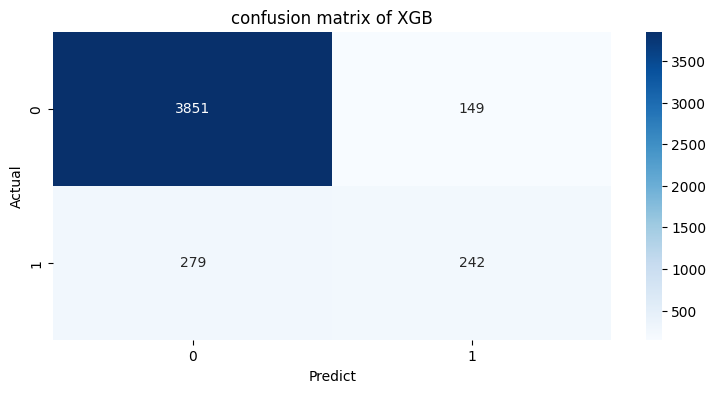

In [ ]:
xgb_result(model,x_tst,y_tst)

Create objective function for Optuna hyperparameter optimization. Random cv is selected, and average balanced accuracy is selected for initial optimization

In [ ]:
def objective_random_cv_optuna(trial):
    #XGB cat type hyperparameters setup
    hp_objective=['binary:logistic','binary:logitraw','binary:hinge']
    hp_importance_type=['gain','total_gain']
    hp_tree_method=['exact','approx','hist']
    #exclude 'gblinear' since this is not linear model
    hp_booster=['gbtree','dart']
    #XGB hyper other parameters setup. colsample_bytree is very bad for performance, min_child_weight might be ok, but without them we have achieved maximum score of training
    xgb_optuna_hpdict={
        'eta':trial.suggest_uniform('eta', 0,1),
        'gamma': trial.suggest_uniform('gamma', 0,10),
        'max_depth': trial.suggest_int("max_depth", 6, 18),
        'reg_alpha' : trial.suggest_uniform('reg_alpha', 0,10),
        'reg_lambda' : trial.suggest_uniform('reg_lambda', 0,10),
        #'colsample_bytree' : trial.suggest_uniform('colsample_bytree',0,1),
        #'min_child_weight' : trial.suggest_uniform('min_child_weight', 0,100),
        'subsample':trial.suggest_uniform('subsample', 0,1),
        'objective':trial.suggest_categorical('objective',hp_objective),
        'importance_type':trial.suggest_categorical('importance_type',hp_importance_type),
        #'tree_method':trial.suggest_categorical('tree_method',hp_tree_method),
        'seed':trial.suggest_int("seed", 0, 1000),
        'booster':trial.suggest_categorical('booster',hp_booster),
        }
    
    tr_df=pro_df_tr.copy()
    df1,k1=train_test_split(tr_df,train_size=0.8,shuffle=True)
    df1,k2=train_test_split(df1,train_size=(0.75),shuffle=True)
    df1,k3=train_test_split(df1,train_size=(2/3),shuffle=True)
    k5,k4=train_test_split(df1,train_size=0.5,shuffle=True)
    a=[k1,k2,k3,k4,k5]
    cv_score=[100,100,100,100,100]
    
    for i in range(len(a)):
        b=a.copy()
        val_x_=b[i].drop('y',axis=1)
        val_y_=b[i]['y']
        del b[i]
        k_tr=pd.DataFrame()
        for j in range(len(b)):
            k_tr=pd.concat([k_tr,b[j]],axis=0)

        train_x_=k_tr.drop('y',axis=1)
        train_y_=k_tr['y']

        hp_clf=opt_xgb_model_optuna(xgb_optuna_hpdict,train_x_,train_y_,val_x_,val_y_)
        
        pred_ = hp_clf.predict(val_x_)
        #f1= f1_score(val_y_, pred_)
        accuracy=balanced_accuracy_score(val_y_,pred_)
        #recall=recall_score(val_y_,pred_)
        #precision=precision_score(val_y_,pred_)
        cv_score[i]=accuracy
        
        #success_pred_ = hp_clf.predict(success_x_)
        #fail_pred_ = hp_clf.predict(fail_x_)
        #f1_= (f1_score(success_y_, success_pred_)*f1_score(fail_y_, fail_pred_))
        #accuracy_=(accuracy_score(success_y_, success_pred_)*accuracy_score(fail_y_, fail_pred_))
        #recall_=(recall_score(success_y_, success_pred_)+recall_score(fail_y_, fail_pred_))/2
        #precision_=(precision_score(success_y_, success_pred_)+precision_score(fail_y_, fail_pred_))/2
        #cv_score[i]=(a1*f1_+a2*accuracy_+a3*recall_+a4*precision_)/(a1+a2+a3+a4)
        #cv_score[i]=accuracy_*recall__
    #print(cv_score)
    #best_score=min(cv_score)
    best_score=sum(cv_score)/len(cv_score)

    return best_score

In [ ]:
#Time_based split cv objective function (not used)
def objective_time_based_cv_optuna(trial):
    #XGB cat type hyperparameters setup
    hp_objective=['binary:logistic','binary:logitraw','binary:hinge']
    hp_importance_type=['gain','total_gain']
    hp_tree_method=['exact','approx','hist']
    #exclude 'gblinear' since this is not linear model
    hp_booster=['gbtree','dart']
    #XGB hyper other parameters setup. colsample_bytree is very bad for performance, min_child_weight might be ok, but without them we have achieved maximum score of training
    xgb_optuna_hpdict={
        'eta':trial.suggest_uniform('eta', 0,0.5),
        'gamma': trial.suggest_uniform('gamma', 2,4),
        'max_depth': trial.suggest_int("max_depth", 6, 18),
        'reg_alpha' : trial.suggest_uniform('reg_alpha', 0,10),
        'reg_lambda' : trial.suggest_uniform('reg_lambda', 0,10),
        #'colsample_bytree' : trial.suggest_uniform('colsample_bytree',0,1),
        #'min_child_weight' : trial.suggest_uniform('min_child_weight', 0,100),
        'subsample':trial.suggest_uniform('subsample', 0.5,1),
        'objective':trial.suggest_categorical('objective',hp_objective),
        'importance_type':trial.suggest_categorical('importance_type',hp_importance_type),
        'tree_method':trial.suggest_categorical('tree_method',hp_tree_method),
        'seed':trial.suggest_int("seed", 800, 1000),
        'booster':trial.suggest_categorical('booster',hp_booster),
        }
    
    #time sequence split use train test split to split the data, continue split the larger portion until we have 5 equal size data. This has nothing with test train
    tr_df=pro_df_tr.copy()
    tr_df=tr_df.sort_values(by=['month','day'])
    df1,k1=train_test_split(tr_df,train_size=0.8,shuffle=False)
    df1,k2=train_test_split(df1,train_size=(0.75),shuffle=False)
    df1,k3=train_test_split(df1,train_size=(2/3),shuffle=False)
    k5,k4=train_test_split(df1,train_size=0.5,shuffle=False)

    #rotate and select the val and train data from the 5 folds, and return the min score of the 5 folds to the hperopt fmin() optimization function
    a=[k1,k2,k3,k4,k5]
    cv_score=[100,100,100,100,100]
    for i in range(len(a)):
        if i==0:
            b=a[i]
        if i>0:
            b=pd.concat([b,a[i]],axis=0)
        k_tr,k_val=train_test_split(b,train_size=0.8,shuffle=False)
        #assign validation set
        train_x_=k_tr.drop('y',axis=1)
        train_y_=k_tr['y']
        val_x_=k_val.drop('y',axis=1)
        val_y_=k_val['y']

        hp_clf=opt_xgb_model_optuna(xgb_optuna_hpdict,train_x_,train_y_,val_x_,val_y_)
        
        pred_ = hp_clf.predict(val_x_)
        #f1= f1_score(val_y_, pred_)
        accuracy=balanced_accuracy_score(val_y_,pred_)
        #recall=recall_score(val_y_,pred_)
        #precision=precision_score(val_y_,pred_)
        cv_score[i]=accuracy
        
        #success_pred_ = hp_clf.predict(success_x_)
        #fail_pred_ = hp_clf.predict(fail_x_)
        #f1_= (f1_score(success_y_, success_pred_)*f1_score(fail_y_, fail_pred_))
        #accuracy_=(accuracy_score(success_y_, success_pred_)*accuracy_score(fail_y_, fail_pred_))
        #recall_=(recall_score(success_y_, success_pred_)+recall_score(fail_y_, fail_pred_))/2
        #precision_=(precision_score(success_y_, success_pred_)+precision_score(fail_y_, fail_pred_))/2
        #cv_score[i]=(a1*f1_+a2*accuracy_+a3*recall_+a4*precision_)/(a1+a2+a3+a4)
        #cv_score[i]=accuracy_*recall__
    #print(cv_score)
    #best_score=min(cv_score)
    best_score=sum(cv_score)/len(cv_score)

    return best_score

Study1 is run with 100 trials to optimize the hyperparameter for better balanced accuracy.

In [ ]:
study1 = optuna.create_study(direction="maximize")
study1.optimize(objective_random_cv_optuna, n_trials=100)
hp_optuna = study1.best_params
hp01=study1.best_params

[I 2024-06-22 12:40:30,862] A new study created in memory with name: no-name-4526945c-f874-4e1d-b6ce-0865a521db95
[I 2024-06-22 12:40:32,107] Trial 0 finished with value: 0.7260225595566823 and parameters: {'eta': 0.47463958585929855, 'gamma': 0.5731276498219673, 'max_depth': 9, 'reg_alpha': 4.289800358093707, 'reg_lambda': 3.4001022782662362, 'subsample': 0.3261641560920837, 'objective': 'binary:hinge', 'importance_type': 'gain', 'seed': 18, 'booster': 'gbtree'}. Best is trial 0 with value: 0.7260225595566823.
[I 2024-06-22 12:40:32,876] Trial 1 finished with value: 0.7248070670313342 and parameters: {'eta': 0.824251619090919, 'gamma': 0.8824612980929225, 'max_depth': 7, 'reg_alpha': 9.815471075233095, 'reg_lambda': 4.53708130548446, 'subsample': 0.3581720747563607, 'objective': 'binary:hinge', 'importance_type': 'total_gain', 'seed': 116, 'booster': 'gbtree'}. Best is trial 0 with value: 0.7260225595566823.
[I 2024-06-22 12:40:35,096] Trial 2 finished with value: 0.5870718985128069 a

The first optimized hyperparameter hp_optuna:

In [ ]:
hp01

{'eta': 0.07515307644937705,
 'gamma': 8.142983479923078,
 'max_depth': 17,
 'reg_alpha': 1.0040684463586094,
 'reg_lambda': 0.6804433417084434,
 'subsample': 0.9472737264861752,
 'objective': 'binary:hinge',
 'importance_type': 'total_gain',
 'seed': 156,
 'booster': 'gbtree'}

The test data balanced accuracy is improved from 0.71 to 0.77

Balanced accuracy:0.77

                 precision    recall  f1-score   support

Not Subscribe 0       0.95      0.95      0.95      4000
    Subscribe 1       0.60      0.60      0.60       521

       accuracy                           0.91      4521
      macro avg       0.77      0.77      0.77      4521
   weighted avg       0.91      0.91      0.91      4521



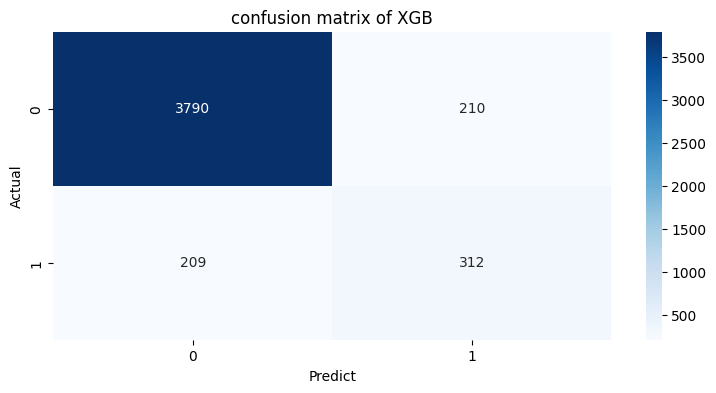

In [ ]:
model1=opt_xgb_model_optuna(hp01,x_tr,y_tr,x_tst,y_tst)
xgb_result(model1,x_tst,y_tst)

It is found that 'objective' is the most important hyperparameters, followed by eta during the first optimization. Next is to study the feature before another hyperparameter finetuning.

In [ ]:
optuna.visualization.plot_param_importances(study1)

## **5. Feature Engineering and Model Tunning**
### **Summary:**
Least important features are removed and re-run Optuna hyperparmater optimization. Final model (model3) has improve balanced accuracy from 0.77 to 0.83

### **Section Highlights:**
1. Less important features are remove in further optimization, final model has reduced features from 37 to 30.
2. Optuna hyperparameter optimization range is reduced to finetune efficiently.

In [ ]:
def feat_importance(model):
    feat_df=pd.DataFrame(data={'Feature':model.feature_names_in_,'Importance':model.feature_importances_,})
    print('Total feature count is',len(feat_df['Feature']))
    
    fig = px.bar(feat_df.sort_values(by='Importance',ascending=False), x='Feature', y='Importance',title="Feature Importance")
    fig.show()

    fig = px.histogram(feat_df, x="Importance",histnorm='percent',nbins=5*len(feat_df),marginal='box',title="Feature Importance Distribution")
    fig.show()

    fig = px.ecdf(feat_df, x="Importance",marginal="histogram",title="Cumulative Distribution of Feature Importance")
    fig.show()

    display(feat_df.sort_values(by='Importance',ascending=False))
    return feat_df

In [ ]:
model_feat1=feat_importance(model1)

Total feature count is 37


,Feature,Importance
4,duration,0.471607
32,poutcome_success,0.161378
0,month,0.115068
1,day,0.051364
35,housing,0.050194
2,age,0.042162
6,pdays,0.039657
29,contact_unknown,0.029161
27,contact_cellular,0.008579
3,balance,0.007020


In [ ]:
def select_feat(model_feat,criteria):
    fe_to_select=model_feat[model_feat['Importance']>criteria]
    fe_to_remove=model_feat[model_feat['Importance']<=criteria]

    print(f'Total {len(fe_to_remove)} features to be removed based on criteria lower than',criteria)
    display(fe_to_remove.sort_values(by='Importance',ascending=False))

    print(f'Total {len(fe_to_select)} features to be retained based on criteria higher than',criteria)
    display(fe_to_select.sort_values(by='Importance',ascending=False))

    return fe_to_select,fe_to_remove

In [ ]:
selected_feat,remove_feat=select_feat(model_feat1,0)

Total 6 features to be removed based on criteria lower than 0


,Feature,Importance
8,job_admin.,0.0
10,job_entrepreneur,0.0
11,job_housemaid,0.0
18,job_unemployed,0.0
19,job_unknown,0.0
26,education_unknown,0.0


Total 31 features to be retained based on criteria higher than 0


,Feature,Importance
4,duration,0.471607
32,poutcome_success,0.161378
0,month,0.115068
1,day,0.051364
35,housing,0.050194
2,age,0.042162
6,pdays,0.039657
29,contact_unknown,0.029161
27,contact_cellular,0.008579
3,balance,0.007020


In [ ]:
def update_feat(fe_to_remove,pro_df_tr_,tr_x_,tst_x_):
    fe_pro_df_tr_=pro_df_tr_.drop(fe_to_remove['Feature'].tolist(),axis=1)
    fe_tr_x_=tr_x_.drop(fe_to_remove['Feature'].tolist(),axis=1)
    fe_tst_x_=tst_x_.drop(fe_to_remove['Feature'].tolist(),axis=1)
    return fe_pro_df_tr_,fe_tr_x_,fe_tst_x_

In [ ]:
fe_pro_df_tr,fe_x_tr,fe_x_tst=update_feat(remove_feat,pro_df_tr,x_tr,x_tst)

In [ ]:
fe_x_tr

,month,day,age,balance,duration,campaign,pdays,previous,job_blue-collar,job_management,...,contact_cellular,contact_telephone,contact_unknown,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown,default,housing,loan
0,5,5,1.266667,1.250000,0.375000,-0.5,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0,1,0
1,5,5,0.333333,-0.308997,-0.134259,-0.5,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0,1,0
2,5,5,-0.400000,-0.328909,-0.481481,-0.5,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0,1,1
3,5,5,0.533333,0.780236,-0.407407,-0.5,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0,1,0
4,5,5,-0.400000,-0.329646,0.083333,-0.5,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,11,17,0.800000,0.278024,3.689815,0.5,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0,0
45207,11,17,2.133333,0.944690,1.277778,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0,0
45208,11,17,2.200000,3.884218,4.384259,1.5,185.0,3.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,0
45209,11,17,1.200000,0.162242,1.518519,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0,0,0


Quick check on the model performance after remove the features. The result is closed to the performance before remove the features. This supports that those removed features are not critical features.

Balanced accuracy:0.77

                 precision    recall  f1-score   support

Not Subscribe 0       0.95      0.95      0.95      4000
    Subscribe 1       0.60      0.60      0.60       521

       accuracy                           0.91      4521
      macro avg       0.77      0.77      0.77      4521
   weighted avg       0.91      0.91      0.91      4521



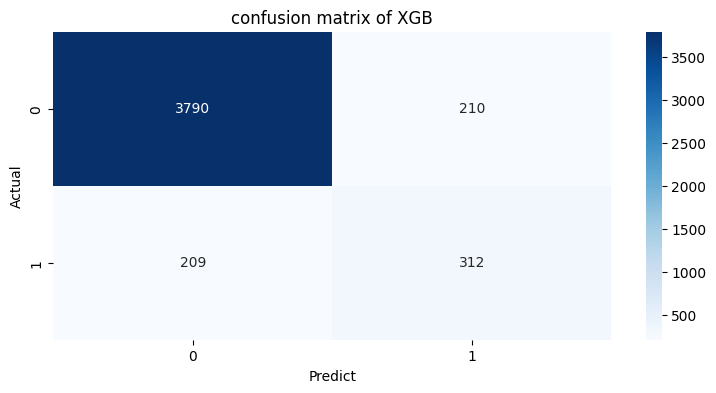

In [ ]:
model=opt_xgb_model_optuna(hp01,fe_x_tr,y_tr,fe_x_tst,y_tst)
xgb_result(model,fe_x_tst,y_tst)

Run the Optuna hyperparameter optimization after remove the features, and fix the 'objective' as 'binary:hinge' since it is found to be most influential (~0.87) during the first optimization. This should help to optimize other hyperparameters more efficiently.

In [ ]:
def objective_random_cv_optuna_fe(trial):
    #XGB cat type hyperparameters setup
    hp_objective=['binary:logistic','binary:logitraw','binary:hinge']
    hp_importance_type=['gain','total_gain']
    hp_tree_method=['exact','approx','hist']
    #exclude 'gblinear' since this is not linear model
    hp_booster=['gbtree','dart']
    #XGB hyper other parameters setup. colsample_bytree is very bad for performance, min_child_weight might be ok, but without them we have achieved maximum score of training
    
    xgb_optuna_hpdict={
        'eta':trial.suggest_uniform('eta', max(0,hp_optuna['eta']-0.1),min(hp_optuna["eta"]+0.1,1)),
        'gamma': trial.suggest_uniform('gamma', max(0,hp_optuna['gamma']-10),hp_optuna["gamma"]+10),
        'max_depth': trial.suggest_int("max_depth", max(0,hp_optuna["max_depth"]-5),min(hp_optuna["max_depth"]+5,24)),
        'reg_alpha' : trial.suggest_uniform('reg_alpha', max(0,hp_optuna["reg_alpha"]-10),hp_optuna["reg_alpha"]+10),
        'reg_lambda' : trial.suggest_uniform('reg_lambda', max(0,hp_optuna["reg_lambda"]-10),hp_optuna["reg_lambda"]+10),
        #'colsample_bytree' : trial.suggest_uniform('colsample_bytree',max(0,hp_optuna["colsample_bytree"]-0.1),min(hp_optuna["colsample_bytree"]+0.1,1)),
        #'min_child_weight' : trial.suggest_uniform('min_child_weight',max(0,hp_optuna["min_child_weight"]-5),hp_optuna["min_child_weight"]+5),
        'subsample':trial.suggest_uniform('subsample', max(0,hp_optuna['subsample']-0.25),min(hp_optuna['subsample']+0.25,1)),
        'objective':'binary:hinge',
        'importance_type':trial.suggest_categorical('importance_type',hp_importance_type),
        #'tree_method':trial.suggest_categorical('tree_method',hp_tree_method),
        'seed':trial.suggest_int("seed", max(0,hp_optuna['seed']-500),hp_optuna['seed']+500),
        'booster':trial.suggest_categorical('booster',hp_booster),
        }    
    
    #replace with pro_df_tr with fe_pro_df_tr
    tr_df=fe_pro_df_tr.copy()
    df1,k1=train_test_split(tr_df,train_size=0.8,shuffle=True)
    df1,k2=train_test_split(df1,train_size=(0.75),shuffle=True)
    df1,k3=train_test_split(df1,train_size=(2/3),shuffle=True)
    k5,k4=train_test_split(df1,train_size=0.5,shuffle=True)
    a=[k1,k2,k3,k4,k5]
    cv_score=[100,100,100,100,100]
    
    for i in range(len(a)):
        b=a.copy()
        val_x_=b[i].drop('y',axis=1)
        val_y_=b[i]['y']
        del b[i]
        k_tr=pd.DataFrame()
        for j in range(len(b)):
            k_tr=pd.concat([k_tr,b[j]],axis=0)

        train_x_=k_tr.drop('y',axis=1)
        train_y_=k_tr['y']

        hp_clf=opt_xgb_model_optuna(xgb_optuna_hpdict,train_x_,train_y_,val_x_,val_y_)
        
        pred_ = hp_clf.predict(val_x_)
        #f1= f1_score(val_y_, pred_)
        accuracy=balanced_accuracy_score(val_y_,pred_)
        #recall=recall_score(val_y_,pred_)
        #precision=precision_score(val_y_,pred_)
        cv_score[i]=accuracy
        
        #success_pred_ = hp_clf.predict(success_x_)
        #fail_pred_ = hp_clf.predict(fail_x_)
        #f1_= (f1_score(success_y_, success_pred_)*f1_score(fail_y_, fail_pred_))
        #accuracy_=(accuracy_score(success_y_, success_pred_)*accuracy_score(fail_y_, fail_pred_))
        #recall_=(recall_score(success_y_, success_pred_)+recall_score(fail_y_, fail_pred_))/2
        #precision_=(precision_score(success_y_, success_pred_)+precision_score(fail_y_, fail_pred_))/2
        #cv_score[i]=(a1*f1_+a2*accuracy_+a3*recall_+a4*precision_)/(a1+a2+a3+a4)
        #cv_score[i]=accuracy_*recall__
    #print(cv_score)
    #best_score=min(cv_score)
    best_score=sum(cv_score)/len(cv_score)

    return best_score

In [ ]:
study2 = optuna.create_study(direction="maximize")
study2.optimize(objective_random_cv_optuna_fe, n_trials=100)
hp_optuna = study2.best_params
hp02=study2.best_params

[I 2024-06-22 13:13:52,365] A new study created in memory with name: no-name-c382c6ad-5e03-47ee-90d7-014355d89e34
[I 2024-06-22 13:13:56,763] Trial 0 finished with value: 0.750335882578374 and parameters: {'eta': 0.11163965477100066, 'gamma': 6.189458326636051, 'max_depth': 21, 'reg_alpha': 9.440775197494286, 'reg_lambda': 9.883038615549538, 'subsample': 0.9465216928824112, 'importance_type': 'total_gain', 'seed': 515, 'booster': 'dart'}. Best is trial 0 with value: 0.750335882578374.
[I 2024-06-22 13:13:59,319] Trial 1 finished with value: 0.7451665981631531 and parameters: {'eta': 0.1718108104021486, 'gamma': 10.859893541606338, 'max_depth': 17, 'reg_alpha': 6.248156107486715, 'reg_lambda': 7.0793597996093025, 'subsample': 0.7969403826550596, 'importance_type': 'total_gain', 'seed': 494, 'booster': 'dart'}. Best is trial 0 with value: 0.750335882578374.
[I 2024-06-22 13:14:00,398] Trial 2 finished with value: 0.7569107127279894 and parameters: {'eta': 0.10000730233067592, 'gamma': 5.

In [ ]:
hp02.update({'objective': 'binary:hinge',
             })
hp02

{'eta': 0.05048155869197371,
 'gamma': 4.123684419610142,
 'max_depth': 17,
 'reg_alpha': 0.5487894695587288,
 'reg_lambda': 0.7363883398550661,
 'subsample': 0.7483511743637902,
 'importance_type': 'total_gain',
 'seed': 388,
 'booster': 'dart',
 'objective': 'binary:hinge'}

Model2 has improved balance accuracy from 0.77 to 0.83

Balanced accuracy:0.83

                 precision    recall  f1-score   support

Not Subscribe 0       0.96      0.96      0.96      4000
    Subscribe 1       0.69      0.70      0.69       521

       accuracy                           0.93      4521
      macro avg       0.82      0.83      0.83      4521
   weighted avg       0.93      0.93      0.93      4521



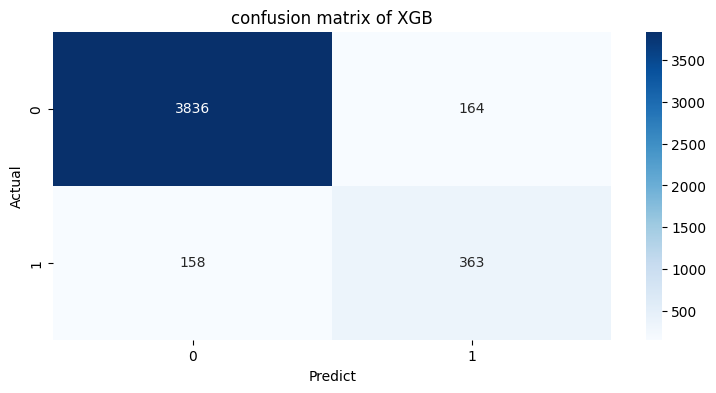

In [ ]:
model2=opt_xgb_model_optuna(hp02,fe_x_tr,y_tr,fe_x_tst,y_tst)
xgb_result(model2,fe_x_tst,y_tst)

After fixing 'objective', 'eta' becomes the most influential hyperparameter(~100%).

In [ ]:
optuna.visualization.plot_param_importances(study2)

In [ ]:
model_feat2=feat_importance(model2)

Total feature count is 31


,Feature,Importance
4,duration,0.397438
26,poutcome_success,0.124382
0,month,0.109211
1,day,0.073537
2,age,0.068131
3,balance,0.049147
6,pdays,0.045730
29,housing,0.033648
23,contact_unknown,0.025225
5,campaign,0.015114


Remove the least important feature.

In [ ]:
selected_feat2,remove_feat2=select_feat(model_feat2,0.000781)

Total 1 features to be removed based on criteria lower than 0.000781


,Feature,Importance
27,poutcome_unknown,0.000043


Total 30 features to be retained based on criteria higher than 0.000781


,Feature,Importance
4,duration,0.397438
26,poutcome_success,0.124382
0,month,0.109211
1,day,0.073537
2,age,0.068131
3,balance,0.049147
6,pdays,0.045730
29,housing,0.033648
23,contact_unknown,0.025225
5,campaign,0.015114


In [ ]:
fe_pro_df_tr,fe_x_tr,fe_x_tst=update_feat(remove_feat2,fe_pro_df_tr,fe_x_tr,fe_x_tst)

In [ ]:
fe_pro_df_tr

,month,day,age,balance,duration,campaign,pdays,previous,job_blue-collar,job_management,...,contact_cellular,contact_telephone,contact_unknown,poutcome_failure,poutcome_other,poutcome_success,default,housing,loan,y
0,5,5,1.266667,1.250000,0.375000,-0.5,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0,1,0,0
1,5,5,0.333333,-0.308997,-0.134259,-0.5,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0,1,0,0
2,5,5,-0.400000,-0.328909,-0.481481,-0.5,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0,1,1,0
3,5,5,0.533333,0.780236,-0.407407,-0.5,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0,1,0,0
4,5,5,-0.400000,-0.329646,0.083333,-0.5,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,11,17,0.800000,0.278024,3.689815,0.5,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1
45207,11,17,2.133333,0.944690,1.277778,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1
45208,11,17,2.200000,3.884218,4.384259,1.5,185.0,3.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0,0,0,1
45209,11,17,1.200000,0.162242,1.518519,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0,0,0,0


Fix the 'eta' and continue optimization.

In [ ]:
def objective_random_cv_optuna_fe2(trial):
    #XGB cat type hyperparameters setup
    hp_objective=['binary:logistic','binary:logitraw','binary:hinge']
    hp_importance_type=['gain','total_gain']
    hp_tree_method=['exact','approx','hist']
    #exclude 'gblinear' since this is not linear model
    hp_booster=['gbtree','dart']
    #XGB hyper other parameters setup. colsample_bytree is very bad for performance, min_child_weight might be ok, but without them we have achieved maximum score of training
    xgb_optuna_hpdict={
        'eta':0.05048155869197371,
        'gamma': trial.suggest_uniform('gamma', max(0,hp_optuna['gamma']-10),hp_optuna["gamma"]+10),
        'max_depth': trial.suggest_int("max_depth", max(0,hp_optuna["max_depth"]-5),min(hp_optuna["max_depth"]+5,24)),
        'reg_alpha' : trial.suggest_uniform('reg_alpha', max(0,hp_optuna["reg_alpha"]-10),hp_optuna["reg_alpha"]+10),
        'reg_lambda' : trial.suggest_uniform('reg_lambda', max(0,hp_optuna["reg_lambda"]-10),hp_optuna["reg_lambda"]+10),
        #'colsample_bytree' : trial.suggest_uniform('colsample_bytree',max(0,hp_optuna["colsample_bytree"]-0.1),min(hp_optuna["colsample_bytree"]+0.1,1)),
        #'min_child_weight' : trial.suggest_uniform('min_child_weight',max(0,hp_optuna["min_child_weight"]-5),hp_optuna["min_child_weight"]+5),
        'subsample':trial.suggest_uniform('subsample', max(0,hp_optuna['subsample']-0.25),min(hp_optuna['subsample']+0.25,1)),
        'objective':'binary:hinge',
        'importance_type':trial.suggest_categorical('importance_type',hp_importance_type),
        #'tree_method':trial.suggest_categorical('tree_method',hp_tree_method),
        'seed':trial.suggest_int("seed", max(0,hp_optuna['seed']-500),hp_optuna['seed']+500),
        'booster':trial.suggest_categorical('booster',hp_booster),
        }
    
    tr_df=fe_pro_df_tr.copy()
    df1,k1=train_test_split(tr_df,train_size=0.8,shuffle=True)
    df1,k2=train_test_split(df1,train_size=(0.75),shuffle=True)
    df1,k3=train_test_split(df1,train_size=(2/3),shuffle=True)
    k5,k4=train_test_split(df1,train_size=0.5,shuffle=True)
    a=[k1,k2,k3,k4,k5]
    cv_score=[100,100,100,100,100]
    
    for i in range(len(a)):
        b=a.copy()
        val_x_=b[i].drop('y',axis=1)
        val_y_=b[i]['y']
        del b[i]
        k_tr=pd.DataFrame()
        for j in range(len(b)):
            k_tr=pd.concat([k_tr,b[j]],axis=0)

        train_x_=k_tr.drop('y',axis=1)
        train_y_=k_tr['y']

        hp_clf=opt_xgb_model_optuna(xgb_optuna_hpdict,train_x_,train_y_,val_x_,val_y_)
        
        pred_ = hp_clf.predict(val_x_)
        #f1= f1_score(val_y_, pred_)
        accuracy=balanced_accuracy_score(val_y_,pred_)
        #recall=recall_score(val_y_,pred_)
        #precision=precision_score(val_y_,pred_)
        cv_score[i]=accuracy
        
        #success_pred_ = hp_clf.predict(success_x_)
        #fail_pred_ = hp_clf.predict(fail_x_)
        #f1_= (f1_score(success_y_, success_pred_)*f1_score(fail_y_, fail_pred_))
        #accuracy_=(accuracy_score(success_y_, success_pred_)*accuracy_score(fail_y_, fail_pred_))
        #recall_=(recall_score(success_y_, success_pred_)+recall_score(fail_y_, fail_pred_))/2
        #precision_=(precision_score(success_y_, success_pred_)+precision_score(fail_y_, fail_pred_))/2
        #cv_score[i]=(a1*f1_+a2*accuracy_+a3*recall_+a4*precision_)/(a1+a2+a3+a4)
        #cv_score[i]=accuracy_*recall__
    #print(cv_score)
    #best_score=min(cv_score)
    best_score=sum(cv_score)/len(cv_score)

    return best_score

In [ ]:
study3 = optuna.create_study(direction="maximize")
study3.optimize(objective_random_cv_optuna_fe2, n_trials=100)
hp_optuna = study3.best_params
hp03=study3.best_params

[I 2024-06-22 14:12:34,350] A new study created in memory with name: no-name-eefce090-721b-490c-9084-75f4617138dd
[I 2024-06-22 14:12:40,240] Trial 0 finished with value: 0.7746973664303788 and parameters: {'gamma': 12.401562931365218, 'max_depth': 15, 'reg_alpha': 0.9627702552074467, 'reg_lambda': 1.408639660198223, 'subsample': 0.5872061666250534, 'importance_type': 'total_gain', 'seed': 748, 'booster': 'dart'}. Best is trial 0 with value: 0.7746973664303788.
[I 2024-06-22 14:12:41,652] Trial 1 finished with value: 0.7558977761566611 and parameters: {'gamma': 13.158170900772761, 'max_depth': 15, 'reg_alpha': 9.622668442961144, 'reg_lambda': 7.7016028071687535, 'subsample': 0.570735611611286, 'importance_type': 'total_gain', 'seed': 130, 'booster': 'gbtree'}. Best is trial 0 with value: 0.7746973664303788.
[I 2024-06-22 14:12:43,165] Trial 2 finished with value: 0.7531969905740727 and parameters: {'gamma': 7.28463172434451, 'max_depth': 14, 'reg_alpha': 9.539540591057397, 'reg_lambda'

In [ ]:
hp03.update({'objective': 'binary:hinge',
             'eta':0.05048155869197371,
             })
hp03

{'gamma': 4.1921127366530415,
 'max_depth': 17,
 'reg_alpha': 1.5049220370882663,
 'reg_lambda': 0.9791045050411954,
 'subsample': 0.805912780872898,
 'importance_type': 'gain',
 'seed': 194,
 'booster': 'gbtree',
 'objective': 'binary:hinge',
 'eta': 0.05048155869197371}

Model3 balanced accuracy is dropped to 0.79. Optimization will be paused and ***the best model is Model2***

Balanced accuracy:0.79

                 precision    recall  f1-score   support

Not Subscribe 0       0.95      0.96      0.95      4000
    Subscribe 1       0.66      0.63      0.64       521

       accuracy                           0.92      4521
      macro avg       0.81      0.79      0.80      4521
   weighted avg       0.92      0.92      0.92      4521



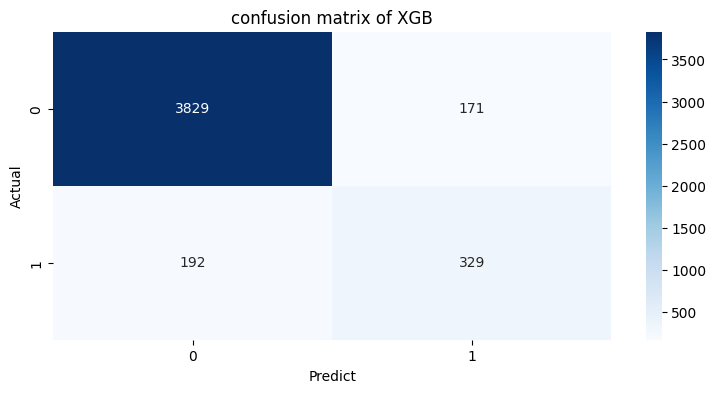

In [ ]:
model3=opt_xgb_model_optuna(hp03,fe_x_tr,y_tr,fe_x_tst,y_tst)
xgb_result(model3,fe_x_tst,y_tst)

In [ ]:
optuna.visualization.plot_param_importances(study3)

In [ ]:
model_feat3=feat_importance(model3)

Total feature count is 30


,Feature,Importance
26,poutcome_success,0.410467
4,duration,0.113305
28,housing,0.066276
23,contact_unknown,0.052049
0,month,0.033358
6,pdays,0.023851
21,contact_cellular,0.023039
2,age,0.021157
13,job_student,0.018161
1,day,0.018023


## **6. Conclusion**
After optimization in hyperparmater and reduce of low importance feature, the best XGB model to predict the bank term deposit subscription from custormer has achieved 0.83 balanced accuracy. In further breakdown for precision metric, the model has 96% probability to correctly 'unsuccessful subscription' and 69% probability to correctly predict 'successful subscription'.

![alt text](model2_confusion.png)

The model has 70% recall for successful subscription, hence the model's feature importance should fairly link to what are the important factors affecting the outcome of campaign. Note that the model is trained with historical data, and it is unlikely to explain the causation between the factor and the outcome, but it can be used to generate hypothesis and to be verified with control experiment.

1. The most important feature is 'duration', which is 'Duration (in seconds) of the last contact with customers during the previous campaign.' This likely that too frequent contact will displease the customer and less likely to get successful subscription.

2. The 2nd important feature is 'poutcome_success'. 'poutcome' is 'Outcome from the previous marketing campaign.' This is likely that if the customer has subscribes the bank term deposition, the customer will be comfortable to subscribe again. The downside was mentioned during the data viz section, most of the poutcome is 'unknown' (see the pie chart below). Suspect there are not record correctly or are missing data.

3. 'Month' and 'Day' are following important features. This is likely related to timing of customer receiving mid-year or year-end bonus, or spending for festival celerebration. The downside is the data provided does not have exact date of outcome, therefore it is less certain about hte timing effect.

![alt text](model2_feat_importance.jpg)

In [3]:
fig = px.pie(df_tr, names="poutcome",title='Majority of poutcome is unknown')
fig.show()